<a href="https://colab.research.google.com/github/mohamed-mkh15/Introduction-to-3D-perception/blob/main/Intro_to_3D_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook has mutiple perception excercises from reading RGBD images to object classification and identification**

### Playing with RGBD images

Libraries to install

In [ ]:
# pip install open3d
# pip install patool

First, I'll read and visualize an RGBDImage from the Redwood dataset [Choi2015]. link: http://redwood-data.org/3dscan/

In [ ]:
!git clone https://github.com/isl-org/redwood-3dscan.git
%cd redwood-3dscan
!python redwood_3dscan.py

In [ ]:
import redwood_3dscan as rws

# Print RGBD scans (list)
print(rws.rgbds)

# Print meshes (list)
print(rws.meshes)

# Print categories (dict: string->list)
print(rws.categories)

# Print all scan_id of the "sofa" category
print(rws.categories["sofa"])

# Download by scan_id "00033"
# Download will be skipped if the resource is unavailable
# e.g. some RGBD images may not come with mesh.
# rws.download_rgbd("00033")  # Save to data/rgbd/00033.zip, if available
# rws.download_mesh("00033")  # Save to data/mesh/00033.ply, if available
# rws.download_video("00033") # Save to data/video/00033.mp4, if available
# rws.download_all("00033")   # Downloads rgbd, mesh, and video together

# Download by category "sofa"
# rws.download_category("sofa")

In [ ]:
import open3d as o3d

# rws.download_mesh("00033")
mesh = o3d.io.read_triangle_mesh("data/mesh/00577.ply")
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh])

Here I'll just extract an RGBD example to view it as it's automatically downloaded as zip file

In [ ]:
import patoolib

patoolib.extract_archive('/content/redwood-3dscan/data/rgbd/00033.zip')

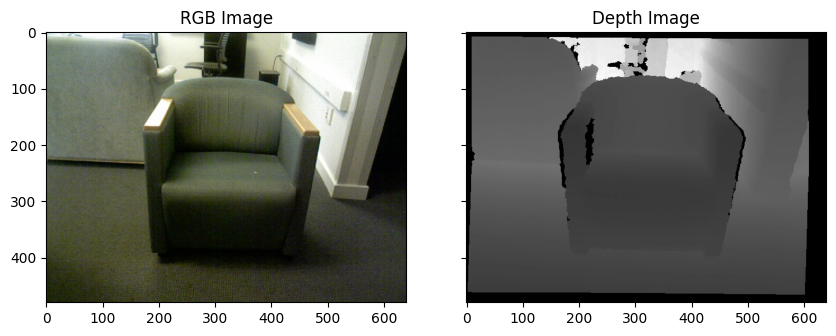

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

depth_image = mpimg.imread('/content/00033/depth/0000001-000000000000.png')
rgb_image = mpimg.imread('/content/00033/rgb/0000001-000000000000.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
f.tight_layout()
ax1.imshow(rgb_image)
ax1.set_title('RGB Image', fontsize=12)

ax2.imshow(depth_image, cmap='gray')
ax2.set_title('Depth Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Now I'll just plot the RGBD as a point cloud

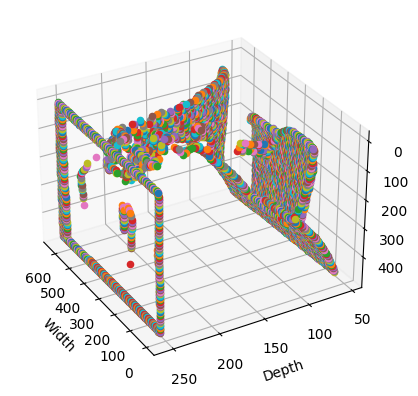

Outputted 12288 of the 307200 points
Results produced in 217.78 seconds


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from time import time

#############################
# Hit Test Run to Visualize #
#############################

start_time = time()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

rows, cols = depth_image.shape

# Send pixels not correctly mapped to the back
max_val = depth_image.max()

count = 0

# Cut down pixels for time purpose
pixel_cut = 5

# Iterate thorugh all the pixels
for x in range(cols):
    for y in range(rows):
        if (x % pixel_cut == 0 and y % pixel_cut == 0):

            # Count points done
            count+=1

            # Get point color for pixel
            pixel_color = [rgb_image[y,x,0],rgb_image[y,x,1],rgb_image[y,x,2]]

            # Get point depth for each particle
            depth = depth_image[y,x]/max_val * 256

            # Send points not correctly mapped to the back
            if depth == 0:
                depth = 256 #max_val
            # print(x, depth, y, pixel_color)
            ax.scatter(x, depth, y, marker='o')

# Axis Labels
ax.set_xlabel('Width')
ax.set_ylabel('Depth')
ax.set_zlabel('Height')

plt.gca().invert_zaxis()

###########################################
# Play with me to change view rotation!
elevation = 30 # Up/Down
azimuth = 300 # Left/Right
###########################################


ax.view_init(elevation, azimuth)

plt.show() # Uncomment if running on your local machine
print ("Outputted {} of the {} points".format(count,rows*cols))
print ("Results produced in {:04.2f} seconds".format(time()-start_time))

### Camera calibration

In [ ]:
%cd ..

/content


Import a chess board image and get it's corners using cv2

In [ ]:
!git clone https://github.com/udacity/RoboND-Camera-Calibration.git
%cd RoboND-Camera-Calibration

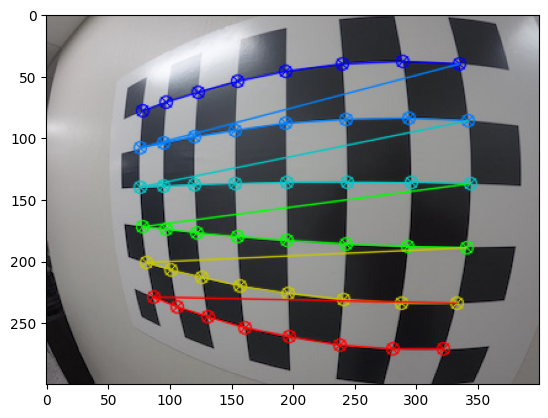

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# prepare object points
nx = 8#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# Make a list of calibration images
images = glob.glob('calibration_small/Cal*.jpg')
# Select any index to grab an image from the list
idx = -1
# Read in the image
img = mpimg.imread(images[idx])

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)


#### Intrensic calirbration


- In general, TO calibrate a camera, we need to calibrate using many images of the test pattern in order to get a good sampling of points across the image plane.  In the exercise below, we'll perform the corner finding step on a couple dozen images to accomplish this.

- Given object points, image points, and the (x, y) shape of the image, we'll perform the calibration using OpenCV.

- The important outputs to focus on here are mtx and dist, which contain the intrinsic camera matrix and distortion coefficients, respectively. The intrinsic camera matrix is typically written like this

![image](https://video.udacity-data.com/topher/2017/June/59558c4d_camera-matrix/camera-matrix.gif)

In the above matrix,
fx and fy correspond to the focal length (and they are equal when pixels are square), while
cx and cy correspond to the camera (optical) center in the (x,y) plane.

There are five distortion coefficients in dist and they are given in this order:

![image](https://video.udacity-data.com/topher/2017/June/595569b0_distortioncoeffs/distortioncoeffs.gif)

where the k's are the radial distortion coefficients and the p's are tangential distortion coefficients. To correct an image for radial and tangential distortion, we'll use the cv2.undistort() function to apply these equations:

![image](https://video.udacity-data.com/topher/2017/June/59556fa2_screen-shot-2017-06-29-at-2.22.29-pm/screen-shot-2017-06-29-at-2.22.29-pm.png)

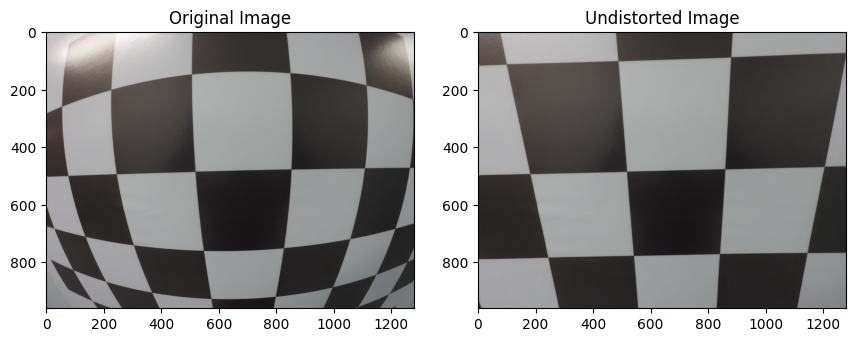

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nx = 8
ny = 6
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny * nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('calibration_wide/GOP*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


img = cv2.imread('calibration_wide/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Perform undistortion
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Extrensic calibration

![image](https://video.udacity-data.com/topher/2017/June/5956b08c_camera-plane-539/camera-plane-539.png)

The relationship between the position of a point in the 2D pixel coordinates and the position of a corresponding point in the 3D world coordinates, is defined by the pinhole camera model:

![image](https://video.udacity-data.com/topher/2017/June/5956b58e_l03a04-extrinsic-calibration/l03a04-extrinsic-calibration.png)

- Where K represents the intrinsic matrix derived in the previous section.

- R and T are the extrinsic parameters which denote the coordinate system transformations from 3D world coordinates to 3D camera coordinates.

- Equivalently, the extrinsic parameters define the position of the camera center and the camera's heading in world coordinates.

- T is the position of the origin of the world coordinate system expressed in coordinates of the camera-centered coordinate system.

- While, the position of the camera C = -R’ T

- Since the extrinsic parameters determine the 3D pose of respective camera in the world coordinates, they can also be used for the process of image registration.

- Image registration refers to transforming the data frame from one camera to match the data frame from the other pixel by pixel.

This is absolutely essential for the creation of an accurate point cloud.

### Point cloud filteration

Next up, we'll explore some of the most commonly used filters from the Point Cloud Library. These filters are:


*   VoxelGrid Downsampling Filter
*   ExtractIndices Filter
*   PassThrough Filter
*   RANSAC Plane Fitting
*   Outlier Removal Filter

In [ ]:
%cd ..

In [ ]:
!git clone https://github.com/udacity/RoboND-Perception-Exercises.git
%cd RoboND-Perception-Exercises

Cloning into 'RoboND-Perception-Exercises'...
remote: Enumerating objects: 708, done.
remote: Total 708 (delta 0), reused 0 (delta 0), pack-reused 708
Receiving objects: 100% (708/708), 11.38 MiB | 9.80 MiB/s, done.
Resolving deltas: 100% (227/227), done.
/content/RoboND-Perception-Exercises


In [ ]:
%cd ..
!git clone https://github.com/strawlab/python-pcl.git
%cd python-pcl

/content
Cloning into 'python-pcl'...
remote: Enumerating objects: 6996, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6996 (delta 0), reused 1 (delta 0), pack-reused 6993
Receiving objects: 100% (6996/6996), 26.35 MiB | 8.87 MiB/s, done.
Resolving deltas: 100% (4908/4908), done.
/content/python-pcl


In [ ]:
!python setup.py build_ext -i

setup.py: error: cannot find PCL, tried
    pkg-config pcl_common-1.9
    pkg-config pcl_common-1.8
    pkg-config pcl_common-1.7
    pkg-config pcl_common-1.6
    pkg-config pcl_common


In [ ]:
!sudo apt-get install libpcl-dev -y

In [ ]:
!conda config --add channels conda-forge # add conda-forge channels

/bin/bash: line 1: conda: command not found


In [ ]:
# Import PCL module
import pcl

# Load point cloud file
cloud = pcl.load_XYZRGB('/content/RoboND-Perception-Exercises/Exercise-1/tabletop.pcd')

# Voxel Grid filter
# Implement Voxel Grid Downsampling here

# Pass Through filter
# Implement a Pass Through Filter here

# RANSAC plane segmentation
# Implement plane segmentation here

# Extract inliers
# Implement inlier extraction here

# Save output point cloud data
# example: filename = 'table.pcd' for table
# pcl.save(cloud, filename)

# Extract outliers

# Save pcd for tabletop objects

ModuleNotFoundError: ignored